## **1. Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao como base.

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

In [3]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

df_unificado = df_unificado.fillna(method='bfill')
train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size
df_unificado = df_unificado.iloc[:-test_size]
print(df_unificado.tail())


# Serie objetivo
y = df_unificado['COP/kg']

# Variables exógenas
X = df_unificado[['TRM', 'COP/kg (internacional)', 'Inflacion', 'COP/kg (futuro)']]

         Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
100 2024-12-30  34900.8  4401.98                46997.39       5.20   
101 2025-01-06  34633.5  4355.51                46596.51       5.22   
102 2025-01-13  34229.2  4343.48                44717.30       5.22   
103 2025-01-20  33817.8  4344.27                47131.29       5.22   
104 2025-01-27  33831.3  4188.46                46874.52       5.22   

     COP/kg (futuro)  
100         46319.09  
101         46450.08  
102         44801.56  
103         47574.84  
104         47202.56  


C:\Users\peter\AppData\Local\Temp\ipykernel_18264\2040355290.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_unificado = df_unificado.fillna(method='bfill')


## **2. Aplicación del modelo a los datos**

In [ ]:
# Definimos un SARIMAX (órdenes como en SARIMA univariado)
order = (1,2,2)
seasonal_order = (1,1,1,26)

model = SARIMAX(y,
                exog=X,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

# Pronóstico a 52 semanas
forecast = results.get_forecast(steps=test_size, exog=X[-test_size:])
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               COP/kg   No. Observations:                  105
Model:             SARIMAX(1, 2, 2)x(1, 1, [1], 26)   Log Likelihood                -425.745
Date:                              Wed, 10 Sep 2025   AIC                            871.489
Time:                                      21:10:35   BIC                            890.201
Sample:                                           0   HQIC                           878.560
                                              - 105                                         
Covariance Type:                                opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TRM                        0.9572      3.798      0.252      0.801      -6

## **3. Visualización de los resultados del forecast**

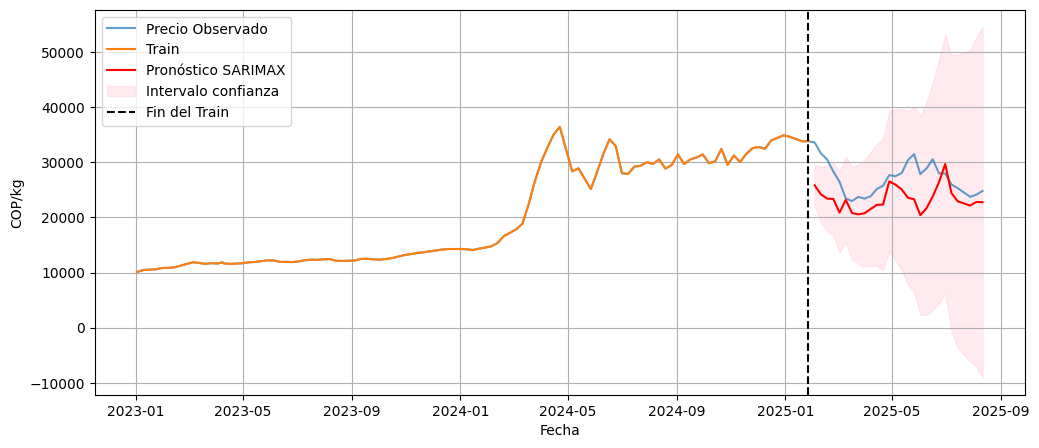

In [12]:
n_train = len(y)
steps = len(pred_mean)

# Index de las fechas donde cae el forecast (las siguientes fechas en df_total después del train)
pred_index = df_total['Fecha'].iloc[n_train:n_train+steps].reset_index(drop=True)

# Asignar ese índice al forecast
pred_mean.index = pred_index
pred_ci.index = pred_index


# Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(df_total['Fecha'], df_total['COP/kg'], label='Precio Observado', color='C0', alpha=0.7)
plt.plot(df_unificado['Fecha'], y, label='Train', color='C1')
plt.plot(pred_mean.index, pred_mean, label='Pronóstico SARIMAX', color='red')

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3, label="Intervalo confianza")
plt.axvline(df_unificado['Fecha'].iloc[-1], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('COP/kg')
plt.legend()
plt.grid(True)
plt.show()